# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [9]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [12]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [15]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(58, 6)


OSError: Cannot save file into a non-existent directory: 'src'

With the data in and wrangled, we can now do some analysis:

count       58.000000
mean     10318.948276
std      11070.974994
min       2000.000000
25%       3500.000000
50%       6650.000000
75%      11300.000000
max      62800.000000
Name: price, dtype: float64


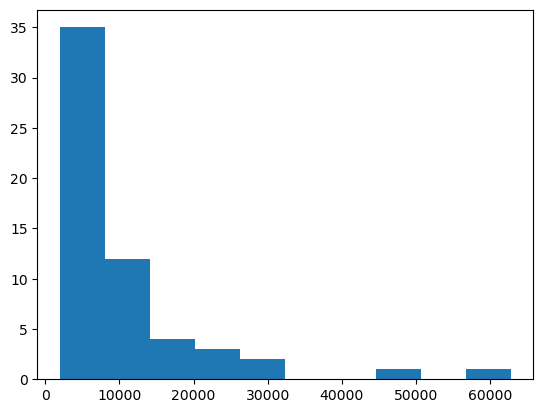

count    54.000000
mean     21.851852
std      15.053875
min       4.000000
25%      13.000000
50%      17.500000
75%      22.000000
max      68.000000
Name: age, dtype: float64


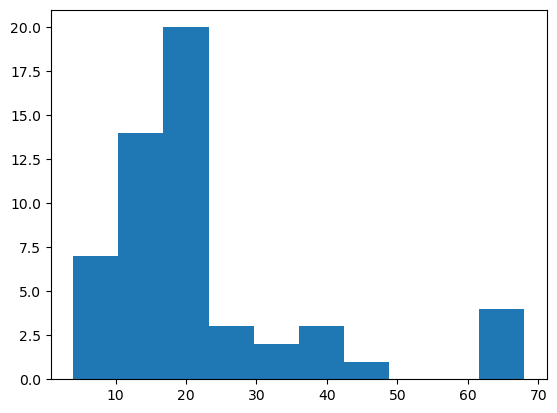

In [17]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [19]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
           count          mean           std      min       25%      50%   
brand                                                                      
audi         1.0  37000.000000           NaN  37000.0  37000.00  37000.0   
bmw          3.0  19966.666667  20813.537261   7900.0   7950.00   8000.0   
chevrolet    4.0  10875.000000   9393.038202   3000.0   3375.00   9000.0   
chevy        3.0  11616.666667  11515.677719   4450.0   4975.00   5500.0   
dodge        1.0  18900.000000           NaN  18900.0  18900.00  18900.0   
ford         3.0  21333.333333  29173.332572   3500.0   4500.00   5500.0   
gmc          2.0  16475.000000  13470.384182   6950.0  11712.50  16475.0   
honda        5.0   5629.800000   2372.328013   2300.0   4700.00   5900.0   
jeep         2.0   9500.000000      0.000000   9500.0   9500.00   9500.0   
lexus        2.0  11175.000000    318.198052  10950.0  11062.50  11175.0   
missing     14.0  10089.214286  16148.241324   2000.0   3312.50   4650.0   
mitsubishi   1.0   7300.000000           NaN   7300.0   7300.00   7300.0   
subaru       1.0   3900.000000           NaN   3900.0   3900.00   3900.0   
toyota       4.0   9549.750000   7072.121340   2199.0   4299.75   9500.0   

                               
                 75%      max  
brand                          
audi        37000.00  37000.0  
bmw         26000.00  44000.0  
chevrolet   16500.00  22500.0  
chevy       15200.00  24900.0  
dodge       18900.00  18900.0  
ford        30250.00  55000.0  
gmc         21237.50  26000.0  
honda        6500.00   8749.0  
jeep         9500.00   9500.0  
lexus       11287.50  11400.0  
missing      6749.75  62800.0  
mitsubishi   7300.00   7300.0  
subaru       3900.00   3900.0  
toyota      14750.00  17000.0

In [20]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                    
           count       mean        std   min   25%   50%   75%   max
brand                                                               
audi         1.0   6.000000        NaN   6.0   6.0   6.0   6.0   6.0
bmw          2.0  15.000000   1.414214  14.0  14.5  15.0  15.5  16.0
chevrolet    4.0  44.000000  16.000000  36.0  36.0  36.0  44.0  68.0
chevy        3.0  20.000000  12.124356   7.0  14.5  22.0  26.5  31.0
dodge        1.0  27.000000        NaN  27.0  27.0  27.0  27.0  27.0
ford         3.0  22.666667   1.154701  22.0  22.0  22.0  23.0  24.0
gmc          1.0  27.000000        NaN  27.0  27.0  27.0  27.0  27.0
honda        5.0  18.000000   9.000000  10.0  13.0  15.0  19.0  33.0
jeep         2.0  22.000000  14.142136  12.0  17.0  22.0  27.0  32.0
lexus        2.0  17.000000   5.656854  13.0  15.0  17.0  19.0  21.0
missing     11.0  30.636364  23.585049   7.0  12.0  20.0  49.0  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.0  17.0  17.0  17.0
subaru       1.0  11.000000        NaN  11.0  11.0  11.0  11.0  11.0
toyota       4.0  15.500000   3.109126  12.0  13.5  15.5  17.5  19.0

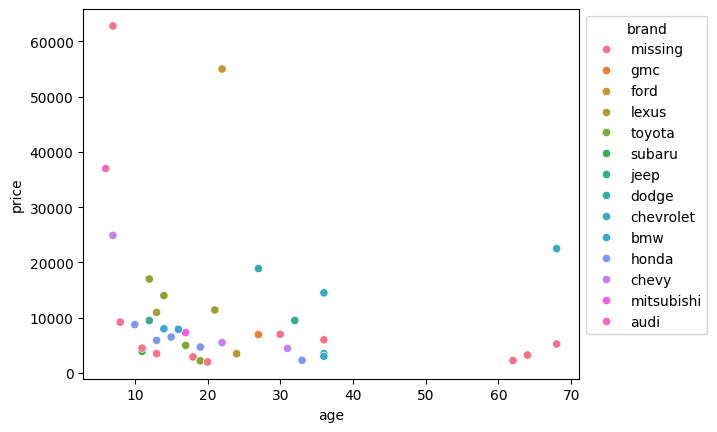

In [21]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.783367 -0.196806
log_age    -0.196806  0.382606
           log_price   log_age
log_price   1.000000 -0.376511
log_age    -0.376511  1.000000


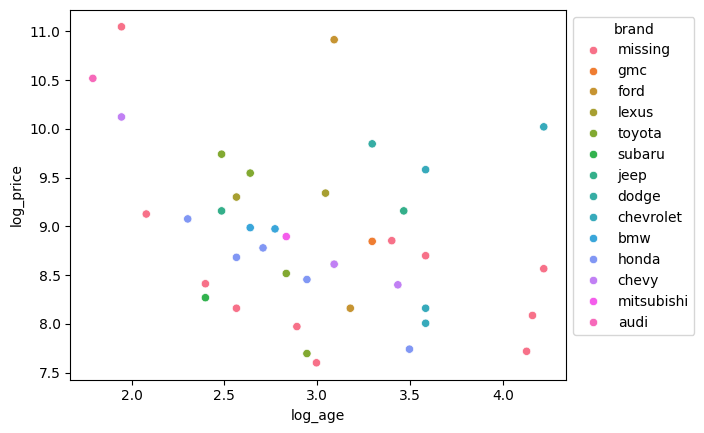

In [22]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [23]:
#Importing the packages that we need in order to scrape, wrangle, and visualize the data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

#Defining the information we will ned when accessing Craigslist and scraping
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/jwa#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

I chose to look at jewelry in the Charlottesville area on Craigslist. I plan to look at price and details of these listings. The details seem to include price and location information. I would like to look at descriptive statistics of the price to see what the maximum and minimum prices of these pieces are, as well as what the mean price of jewelry is. After cleaning the data, I would also like to examine relationships between location and price!

In [26]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want
print(listings)

[<li class="cl-static-search-result" title="Seiko Watch">
<a href="https://charlottesville.craigslist.org/jwl/d/spotsylvania-seiko-watch/7823041106.html">
<div class="title">Seiko Watch</div>
<div class="details">
<div class="price">$50</div>
<div class="location">
                        Spotsylvania
                    </div>
</div>
</a>
</li>, <li class="cl-static-search-result" title="Vintage Monet Gold Tone Black Enamel Pierced Earrings">
<a href="https://charlottesville.craigslist.org/jwl/d/quinque-vintage-monet-gold-tone-black/7823595047.html">
<div class="title">Vintage Monet Gold Tone Black Enamel Pierced Earrings</div>
<div class="details">
<div class="price">$18</div>
</div>
</a>
</li>, <li class="cl-static-search-result" title="Reed and Barton Damascene Choker and Bracelet">
<a href="https://charlottesville.craigslist.org/jwl/d/earlysville-reed-and-barton-damascene/7818778068.html">
<div class="title">Reed and Barton Damascene Choker and Bracelet</div>
<div class="details">

In [28]:
jewl_data=[] #Creating an empty dictionary
#Now we create a for-loop to parse the html
for k in range(len(listings)):
    link_tag = listings[k].find(href=True)
    tag_title = listings[k].find('div', class_='title')
    tag_details = listings[k].find('div', class_='details')
#Price and Location are Nested, so here we are extracting the tags
    tag_price = tag_details.find('div', class_='price') if tag_details else None
    tag_location = tag_details.find('div', class_='location') if tag_details else None
#Getting the text from the html tags, here we are able to actually extract the text and set up an if, else (in case we have missing values)
    title = tag_title.get_text(strip=True) if tag_title else "No title available"
    price = tag_price.get_text(strip=True) if tag_price else "No price available"
    location = tag_location.get_text(strip=True) if tag_location else "No location available"
    link = link_tag['href'] if link_tag else "No link available"

    
    print("Jewelry:", title)
    print("Price:", price)
    print("Location:", location)
    print("Link:", link)

    jewl_data.append({'Jewelry':title,'Price':price,'Location':location,'Link':link}) #Filling out dictionary with key:value pairs

Jewelry: Seiko Watch
Price: $50
Location: Spotsylvania
Link: https://charlottesville.craigslist.org/jwl/d/spotsylvania-seiko-watch/7823041106.html
Jewelry: Vintage Monet Gold Tone Black Enamel Pierced Earrings
Price: $18
Location: No location available
Link: https://charlottesville.craigslist.org/jwl/d/quinque-vintage-monet-gold-tone-black/7823595047.html
Jewelry: Reed and Barton Damascene Choker and Bracelet
Price: $40
Location: Earlysville
Link: https://charlottesville.craigslist.org/jwl/d/earlysville-reed-and-barton-damascene/7818778068.html
Jewelry: new jeweled heart trinket box with hanger
Price: $35
Location: Earlysville
Link: https://charlottesville.craigslist.org/jwl/d/earlysville-new-jeweled-heart-trinket/7818774505.html
Jewelry: Jewlery by the 5 pounds for $25 each vintage and antique. Earrings, necklaces, b
Price: $25
Location: Charlottesville
Link: https://charlottesville.craigslist.org/jwl/d/charlottesville-jewlery-by-the-pounds/7823431207.html
Jewelry: > LADIES RING - AME

In [30]:
print(jewl_data) #Checking to dictionary to make sure it was appended

[{'Jewelry': 'Seiko Watch', 'Price': '$50', 'Location': 'Spotsylvania', 'Link': 'https://charlottesville.craigslist.org/jwl/d/spotsylvania-seiko-watch/7823041106.html'}, {'Jewelry': 'Vintage Monet Gold Tone Black Enamel Pierced Earrings', 'Price': '$18', 'Location': 'No location available', 'Link': 'https://charlottesville.craigslist.org/jwl/d/quinque-vintage-monet-gold-tone-black/7823595047.html'}, {'Jewelry': 'Reed and Barton Damascene Choker and Bracelet', 'Price': '$40', 'Location': 'Earlysville', 'Link': 'https://charlottesville.craigslist.org/jwl/d/earlysville-reed-and-barton-damascene/7818778068.html'}, {'Jewelry': 'new jeweled heart trinket box with hanger', 'Price': '$35', 'Location': 'Earlysville', 'Link': 'https://charlottesville.craigslist.org/jwl/d/earlysville-new-jeweled-heart-trinket/7818774505.html'}, {'Jewelry': 'Jewlery by the 5 pounds for $25 each vintage and antique. Earrings, necklaces, b', 'Price': '$25', 'Location': 'Charlottesville', 'Link': 'https://charlottesv

In [32]:
#Data wrangling, here we begin to clean the data
df = pd.DataFrame.from_dict(jewl_data)
df['Jewelry'] = df['Jewelry'].str.lower() #Making all of the jewlery lowercase to improve consistency
df['Price'] = df['Price'].str.replace(',','') #Getting rid of the commas to work with numeric later
df['Price'] = df['Price'].str.replace('$','') #Getting rid of the dollar sign to work with numeric later
df['Price'] = pd.to_numeric(df['Price'],errors='coerce') #Casting the price column to numeric. This makes analysis easier. It's hard to work with strings.
df['Location'] = df['Location'].str.capitalize() #Capitalizing location in order to improve consistency
df.to_csv('jewelry.csv', index=False) #Save data in case of a disaster
df.head(10) #Examining the dataframe
df['Price'].unique() #Looking at the values in the array to see if anything seems outlying

array([  50,   18,   40,   35,   25,    0,   10,   15,  350,   20, 1500,
        300, 9500,  400,  200,  150,  125, 1200], dtype=int64)

count      24.000000
mean      634.708333
std      1935.617382
min         0.000000
25%        15.000000
50%        45.000000
75%       312.500000
max      9500.000000
Name: Price, dtype: float64


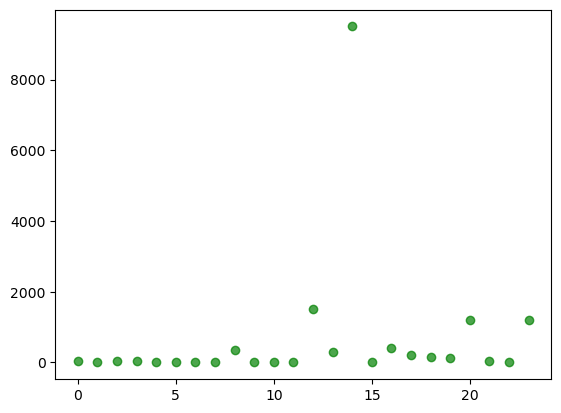

In [34]:
print(df['Price'].describe()) #Looking at the descriptive statistics of the Price column to start exploring the values and their ranges
plt.scatter(df.index,df['Price'],color='green',alpha=0.7)  #Creating a scatterplot of the price variable            
plt.show()
filtered_data = df[df['Price'] != 9500] #The scatterplot is hard to read because of one very obviously outlying variable, and the graph also has a lot more potential

Text(0.5, 1.0, 'Scatterplot of Jewelry Price by Location')

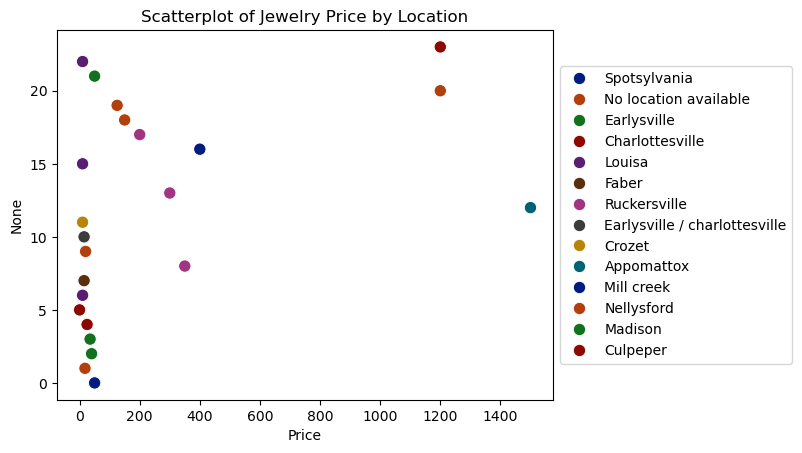

In [36]:
sns.scatterplot(data=filtered_data, x='Price', y=filtered_data.index, hue='Location', palette='dark', s=80) #Using seaborn to create a scatterplot
#We are using the filtered data to be able to better look at the other points, on the x-axis we have Price, and then the points are colored based on location
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5)) #Fixing the location of the legend to be to the right of the graph
plt.title('Scatterplot of Jewelry Price by Location') #Adding a title


Based on this graph we can see jewelry prices in different towns around Charlottesville. It seems that there are some more expensive pieces on sale near Ruckersville, perhaps this suggests there is something of value there.There seems to be another expensive piece of jewelry in Appomattox.Jewelry selling in Charlottesville seems to be on the cheaper end (no family heirlooms for sale here ;))

Text(0.5, 1.0, 'Boxplot with Jewelry Priced Closer to Mean')

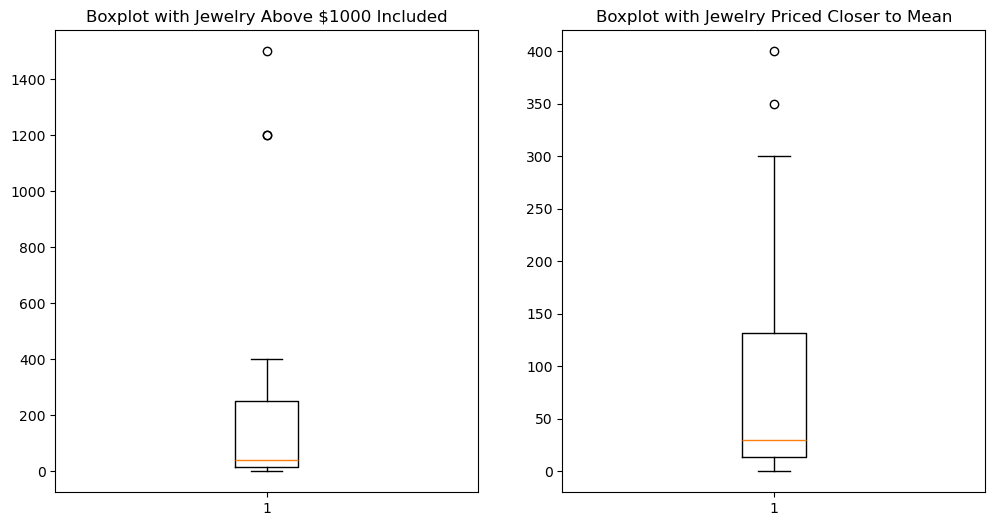

In [39]:
xtra_filtered_data = filtered_data[(filtered_data['Price'] != 1500) & (filtered_data['Price'] != 1200)] #I created a boxplot with the previous "filtered_data" and still found it rather difficult to read, so I decided to exclude the two outlier points to examine the lower-end prices
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) #I proceed to create the boxplots, I looked this method up. I wanted to see the two boxplots side by side to view how they changed without the two points
axes[0].boxplot(filtered_data['Price']) #Setting the axis for this first graph to be on and plotting (using filtered_data df)
axes[0].set_title("Boxplot with Jewelry Above $1000 Included") #Adding a title
axes[1].boxplot(xtra_filtered_data['Price']) #Setting the axis for the second graph and plotting using the newly created xtra_filtered_data
axes[1].set_title("Boxplot with Jewelry Priced Closer to Mean") #Adding a title

The second boxplot is much more telling of the range of the prices. Unrelated, the mean also becomes more accurate, for the two expensive pieces aren't dragging it right. From this boxplot we can tell. The max within the range that isn't an outlier becomes about $200.

It seems that most jewelry in the Charlottesville area is priced at around $25. We can see this in the median, which is closer to the 1st quartile, so the data is skewed towards this value. The graph would have a tail on the right side were individual, more expensive pieces would be.

Overall, there isn't a lot of data on jewelry in the Charlottesville area right now. It's not a hot hit. At the same time, we see some important information about pricing, and are able to conclude that unless the pieces are of unusually high value, they range around $0-$200. It seems that maybe someone in Ruckersville has some higher-value pieces, if the person searching for jewelry is interested in something a bit more high-end.